# Examples
In this Notebook, we provide a few examples comparing the several optimization methods.\
We organize the Notebook as follows:
* First, we visualize the type of data and the graphs we consider:
    * Display examples of local data for the binary classification task.
    * Display examples of local data for the Linear Regression task.
    * Display of the several fixed topology graphs we studied.
    * Display of the random geometric graphs used for the time-varying setting, with 2 different values of parameter $\chi$.
* Then, we compare the 4 optimizers we support ([MSDA](https://arxiv.org/pdf/1702.08704.pdf), [ADOM+](https://openreview.net/attachment?id=L8-54wkift&name=supplementary_material), [Continuized](https://arxiv.org/pdf/2106.07644.pdf), [DADAO](https://hal.archives-ouvertes.fr/hal-03737694/document)).

## Visualization of the type of data and graphs considered

In [1]:
import data
import importlib
importlib.reload(data)
from data import create_data, create_sample_data
from visualization import plot_3_classif, plot_3_reg, plot_all_fixed_graphs, plot_2_time_varying_graph_sequence

In [2]:
# Variables for the problem
n_workers=20
n_samples= n_workers*100

### Data 1: Binary Classification

torch.Size([20, 100, 2])
torch.Size([20, 100, 1])


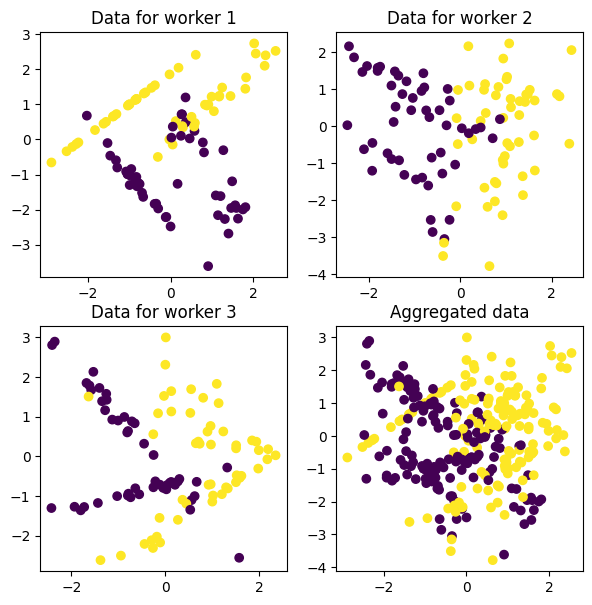

In [3]:
dim=2
classification = True
data, labels = create_sample_data(n_samples, dim, n_workers, classification)
print(data.shape)
print(labels.shape)
plot_3_classif(data, labels)

### Data 2: Linear Regression

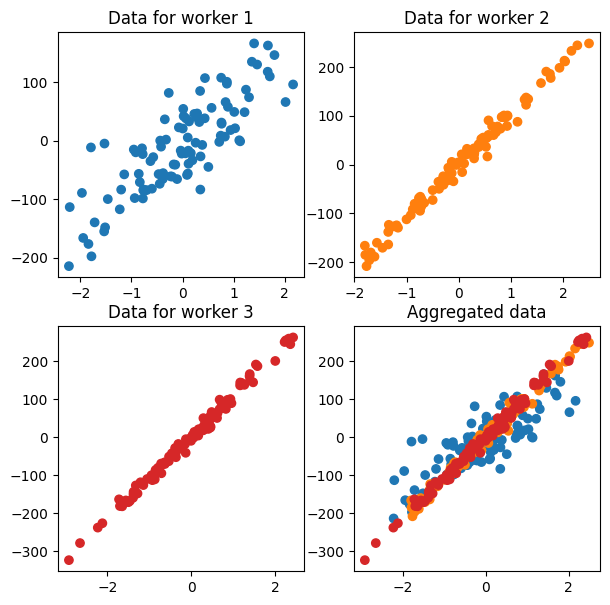

In [4]:
dim=1
classification = False
data, labels = create_sample_data(n_samples, dim, n_workers, classification)
plot_3_reg(data, labels)

### Graphs 1: Fixed topology

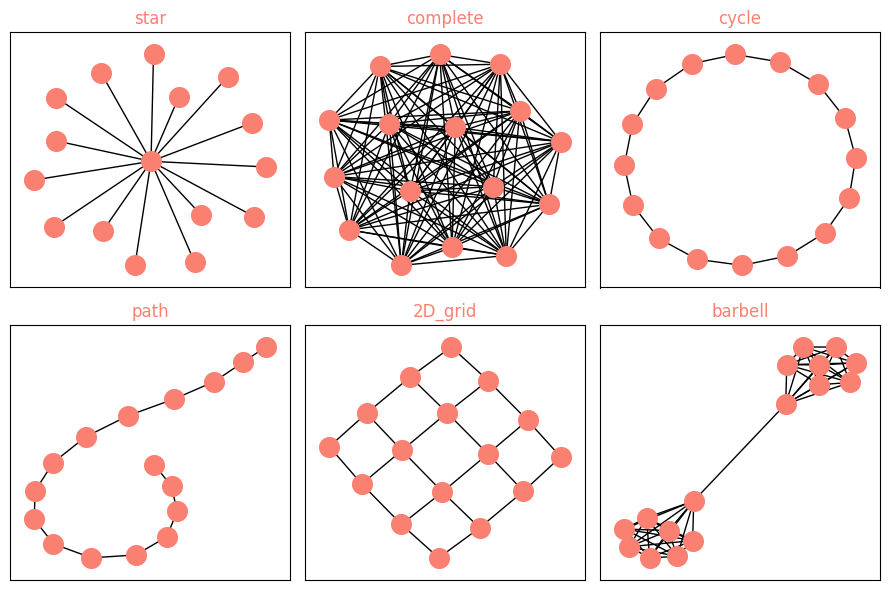

In [5]:
n_workers = 16
plot_all_fixed_graphs(n_workers)

### Graphs 2: Varying topology

We plot 2 sequences of 3 random geometric graphs (on which we forced the connectedness), with 2 different values of $\chi$ _( the $\chi$ displayed is the worst encountered in the sequence)_.\
In practice, we cycled through sequences of 50 graphs to simulate the time-varying setting, as done in [ADOM+](https://openreview.net/attachment?id=L8-54wkift&name=supplementary_material).

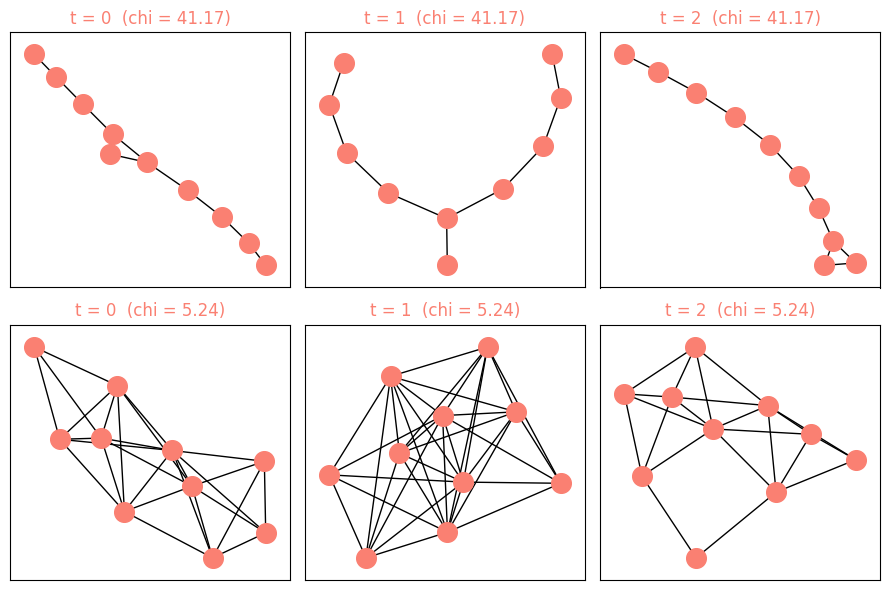

In [6]:
n_workers=10
plot_2_time_varying_graph_sequence(n_workers)

## Run the optimizers

#### Imports

In [7]:
import numpy as np
from main import main
from utils import compute_regularity_constants
import data
import importlib
importlib.reload(data)
from data import create_K_graphs, create_data
import visualization
import importlib
importlib.reload(visualization)
from visualization import print_communication_rates_fixed_topology, Args_for_main, plot_losses, plot_all_losses

import warnings
warnings.filterwarnings('ignore')

D:\python-learn\mfti\opt\env\Lib\site-packages\torch\__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


#### Data and Graphs specification

In [261]:
# Variables for the graphs
n_workers = 50
radius = 1
id_graph_type = -1

list_graph_name = ['star', 'complete', 'cycle', 'path', '2D_grid', 'barbell', 'random_geom']
graph_type = list_graph_name[id_graph_type]
# create 50 graphs of the type considered
list_G, list_W, list_L_norm, chi_1_star, chi_2_star, chi_star = create_K_graphs(n_workers, graph_type, radius)
# display the several communication rates
print_communication_rates_fixed_topology(list_G, list_L_norm, chi_1_star, chi_2_star, chi_star, graph_type)

 Communication rates for the different methods on the random_geom graph with 50 nodes. 
 We print the expected number of edges activated between two expected global rounds of gradient steps. 

 ADOM+ (ADOM+VR): 1194 
 ADOM+ (ADOM+VR) with Multi-Consensus : 2388 


$f_i(\theta, X, y) = (1/m)*\Sigma_{j=1}^m (< x_{ij},  \theta > - y_{ij})^2$ \
$f_i(\theta, X, y) = (1/m)*\Sigma_{j=1}^m \log(1 + exp(-y_{ij} < x_{ij}, \theta >)) + \mu/2 || \theta ||^2$

In [289]:
import data
import importlib
import utils
importlib.reload(data)
importlib.reload(utils)
import matplotlib.pyplot as plt

from utils import compute_regularity_constants
from data import create_data

# Variables for the datasets and task considered
# n_samples = 100 * n_workers

classification = True
# # dataset_name = "cpusmall.txt" #12
# dataset_name = "cadata.txt"   #8
dataset_name = "a9a.txt"      #123
# dataset_name = "w8a.txt"      #300
dim = 123
data, labels = create_data(n_samples, dim, n_workers, classification, dataset_name)

# dim=2
# n_samples=300*n_workers
# data, labels = create_sample_data(n_samples, dim, n_workers, classification)

# Regularity constants
mu, L = compute_regularity_constants(data, classification)
mu = 0.05
print(" Strong convexity coefficient : %.5f \n Smoothness coefficient : %.5f"%(mu,L))


# Initialize the arguments
args = Args_for_main(None, data, labels, classification, mu, L, dim, n_workers, chi_star, chi_1_star, chi_2_star, None, None, None, list_G, list_W, graph_type, steps=300)

 Strong convexity coefficient : 0.05000 
 Smoothness coefficient : 3.47581


#### [Algoritms]

$
f_i(\theta, X, y) = (1/m)*sum_{j=1}^m \log(1 + exp(-y_{ij} < x_{ij}, \theta >)) + \mu/2 || \theta ||^2
$


100%|██████████| 1000/1000 [00:09<00:00, 107.86it/s]


f_star sklearn :  None         |  f(x_bar) ADOMplusVR :  0.38728243472183244


100%|██████████| 1000/1000 [00:08<00:00, 114.69it/s]


f_star sklearn :  None         |  f(x_bar) ADOMplus :  0.3872837796215338


100%|██████████| 1000/1000 [00:08<00:00, 121.18it/s]


f_star sklearn :  None         |  f(x_bar) AccGT :  0.38735807930180693


100%|██████████| 1000/1000 [00:07<00:00, 138.23it/s]


f_star sklearn :  None         |  f(x_bar) AccVRExtra :  0.38728230217908854


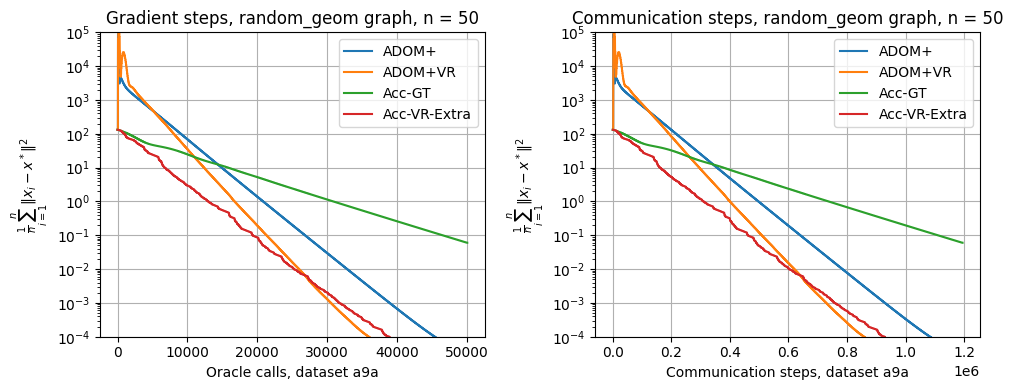

In [404]:
import main
import importlib
importlib.reload(main)

args.use_multi_consensus = False
args.steps = 1000

args.optimizer_name = "ADOMplusVR"
opt_adom_vr, grad_loss_adom_vr, com_loss_adom_vr = main.main(args)
# plot_losses(grad_loss_adom_vr, com_loss_adom_vr, 'ADOM+VR', graph_type, n_workers)

args.optimizer_name = "ADOMplus"
opt_adom, grad_loss_adom, com_loss_adom = main.main(args)
# plot_losses(grad_loss_adom, com_loss_adom, 'ADOM+', graph_type, n_workers)

args.optimizer_name = "AccGT"
opt_accgt, grad_loss_accgt, com_loss_accgt = main.main(args)

args.optimizer_name = "AccVRExtra"
opt_acc_vr, grad_loss_acc_vr, com_loss_acc_vr = main.main(args)

f = plt.figure(figsize=(10, 4))
ax0 = f.add_subplot(121)
ax1 = f.add_subplot(122)
ax0.plot(np.arange(len(grad_loss_adom)), np.array(grad_loss_adom), label=r"ADOM+")
ax0.plot(np.arange(len(grad_loss_adom_vr)), np.array(grad_loss_adom_vr), label=r"ADOM+VR")
ax0.plot(np.arange(len(grad_loss_accgt)), np.array(grad_loss_accgt), label=r"Acc-GT")
ax0.plot(np.arange(len(grad_loss_acc_vr)), np.array(grad_loss_acc_vr), label=r"Acc-VR-Extra")
ax0.set(
    xlabel="Oracle calls, dataset a9a",
    ylabel=r"$\frac{1}{n} \sum_{i=1}^{n}\Vert x_i - x^*\Vert^2$",
    title="Gradient steps, %s graph, n = %d" % (graph_type, n_workers),
    yscale="log",
    ylim=(1e-4, 1e5)
)
ax0.legend(loc="upper right")
ax1.plot(np.arange(len(com_loss_adom)), np.array(com_loss_adom), label=r"ADOM+")
ax1.plot(np.arange(len(com_loss_adom_vr)), np.array(com_loss_adom_vr), label=r"ADOM+VR")
ax1.plot(np.arange(len(com_loss_accgt)), np.array(com_loss_accgt), label=r"Acc-GT")
ax1.plot(np.arange(len(com_loss_acc_vr)), np.array(com_loss_acc_vr), label=r"Acc-VR-Extra")
ax1.set(
    xlabel="Communication steps, dataset a9a",
    ylabel=r"$\frac{1}{n} \sum_{i=1}^{n}\Vert x_i - x^*\Vert^2$",
    title="Communication steps, %s graph, n = %d" % (graph_type, n_workers),
    yscale="log",
    ylim=(1e-4, 1e5)
)
ax1.legend(loc="upper right")
plt.tight_layout()

for ax in (ax0, ax1):
    ax.grid()
plt.show()

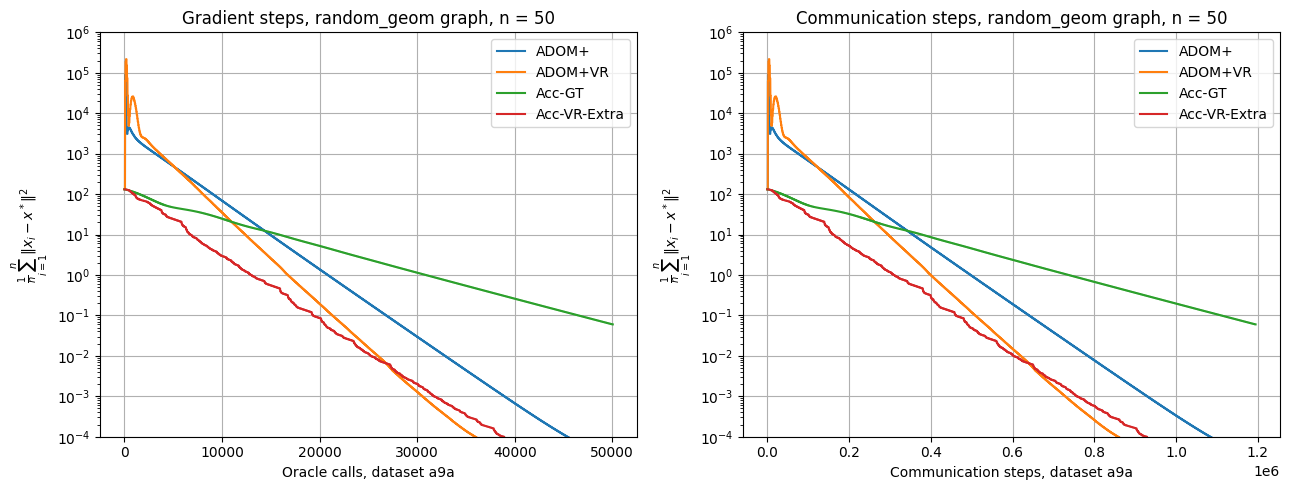

In [405]:
f = plt.figure(figsize=(13, 5))
ax0 = f.add_subplot(121)
ax1 = f.add_subplot(122)
ax0.plot(np.arange(len(grad_loss_adom)), np.array(grad_loss_adom), label=r"ADOM+")
ax0.plot(np.arange(len(grad_loss_adom_vr)), np.array(grad_loss_adom_vr), label=r"ADOM+VR")
ax0.plot(np.arange(len(grad_loss_accgt)), np.array(grad_loss_accgt), label=r"Acc-GT")
ax0.plot(np.arange(len(grad_loss_acc_vr)), np.array(grad_loss_acc_vr), label=r"Acc-VR-Extra")
ax0.set(
    xlabel="Oracle calls, dataset a9a",
    ylabel=r"$\frac{1}{n} \sum_{i=1}^{n}\Vert x_i - x^*\Vert^2$",
    title="Gradient steps, %s graph, n = %d" % (graph_type, n_workers),
    yscale="log",
    ylim=(1e-4, 1e6)
)
ax0.legend(loc="upper right")
ax1.plot(np.arange(len(com_loss_adom)), np.array(com_loss_adom), label=r"ADOM+")
ax1.plot(np.arange(len(com_loss_adom_vr)), np.array(com_loss_adom_vr), label=r"ADOM+VR")
ax1.plot(np.arange(len(com_loss_accgt)), np.array(com_loss_accgt), label=r"Acc-GT")
ax1.plot(np.arange(len(com_loss_acc_vr)), np.array(com_loss_acc_vr), label=r"Acc-VR-Extra")
ax1.set(
    xlabel="Communication steps, dataset a9a",
    ylabel=r"$\frac{1}{n} \sum_{i=1}^{n}\Vert x_i - x^*\Vert^2$",
    title="Communication steps, %s graph, n = %d" % (graph_type, n_workers),
    yscale="log",
    ylim=(1e-4, 1e6)
)
ax1.legend(loc="upper right")
plt.tight_layout()

for ax in (ax0, ax1):
    ax.grid()
plt.show()

#### [GT-PAGE]

100%|██████████| 500/500 [00:02<00:00, 188.58it/s]


f_star sklearn :  None         |  f(x_bar) GTPAGE :  0.6931471805441609


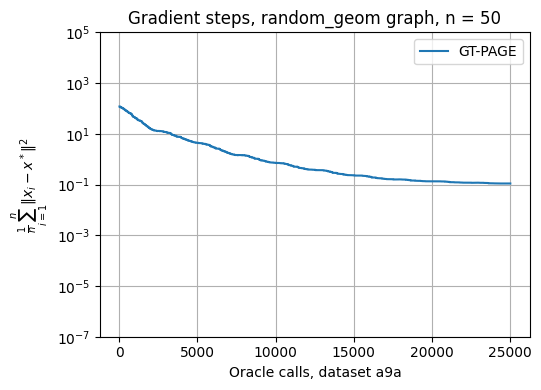

In [285]:
import main
import importlib
importlib.reload(main)

args.use_multi_consensus = False

# args.steps = 50
# args.optimizer_name = "GT_SARAH"
# opt_sarah, grad_loss_sarah, com_loss_sarah = main.main(args)
# plot_losses(grad_loss_sarah, com_loss_sarah, 'GT-SARAH', graph_type, n_workers)

args.steps = 500
args.optimizer_name = "GTPAGE"
opt_page, grad_loss_page, com_loss_page = main.main(args)
# plot_losses(grad_loss_page, com_loss_page, 'GT-PAGE', graph_type, n_workers)
# print(grad_norm)
f = plt.figure(figsize=(10, 4))
ax0 = f.add_subplot(121)
ax0.plot(np.arange(len(grad_loss_page)), np.array(grad_loss_page), label=r"GT-PAGE")
# ax0.plot(np.arange(len(grad_loss_sarah)), np.array(grad_loss_sarah), label=r"GT-SARAH")
ax0.set(
    xlabel="Oracle calls, dataset a9a",
    ylabel=r"$\frac{1}{n} \sum_{i=1}^{n}\Vert x_i - x^*\Vert^2$",
    title="Gradient steps, %s graph, n = %d" % (graph_type, n_workers),
    yscale="log",
    ylim=(1e-7, 1e5)
)
ax0.legend(loc="upper right")
plt.tight_layout()
ax0.grid()
plt.show()